
# **Automatically classify consumer goods**

##***Preprocess text data to obtain a usable data set***

*Place de marché* is a company that wants to launch an e-commerce marketplace.
Manual classification of items by sellers is unreliable and limited.

As a Data Scientist within this company, I have to evaluate the feasibility of an automatic product classification system, using photos and descriptions. My work includes data preprocessing, feature extraction, reduction to 2 dimensions for visualization, and category clustering analysis.
Text extraction methods like bag-of-words, words/sentences embedding with FastText, BERT and USE will be used here.

*NB: The images and descriptions as well as all the data used here are public data available on the website of the company “Marketplace” and are not intellectual property.*

<u><strong>Summary</strong></u> :<br>
<br>
<strong>Tools</strong> <a href="https://colab.research.google.com/drive/1DgoTEXw0V6mIRiM88yLpUZnpbKx6NBwW#scrollTo=ad04d6df">(here)</a><br><br>
<strong>I. Preprocess text data to obtain a usable data set</strong><br>
     -- A. Exploratory data analysis <a href="https://colab.research.google.com/drive/1DgoTEXw0V6mIRiM88yLpUZnpbKx6NBwW#scrollTo=f6165234">(here)</a><br>
     ---- <i>☛ Data description and cleaning<br>
     ---- ☛ Concatenating text values and cleaning product categories<br>
     ---- ☛ Tokenize products descriptions<br>
     ---- ☛ Apply lemmatizer and stemmer separately to tokens, then choose the most effective<br>
     ---- ☛ Top 10 most common lemmas<br>
     ---- ☛ Descriptive statistics on lemma length and diversity<br>
     ---- ☛ Word frequency threshold with Bag of Words and TF-IDF models</i><br>
     -- B. Words/Sentences Embedding <a href="https://colab.research.google.com/drive/1DgoTEXw0V6mIRiM88yLpUZnpbKx6NBwW#scrollTo=3ce16c9a">(here)</a><br>
     ---- <i>☛ Word embedding using FastText<br>
     ---- ☛ Sentences embedding using BERT<br>
     ---- ☛ Sentences embedding using USE</i><br>

****

### **Tools**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install fasttext

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import warnings
import random
import string
import nltk
import time
import fasttext
import optuna
import tensorflow_hub as hub
import tensorflow as tf
from matplotlib.collections import LineCollection

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import manifold
from sklearn import metrics
from sklearn import cluster
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from transformers import TFAutoModel, AutoTokenizer, BertTokenizer
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True  # Permet à PIL de charger des images tronquées

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def split_column(df, column_name):
    """
    Split a DataFrame column into multiple columns using space as the separator.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the column to split.
    column_name (str): The name of the column to split.

    Returns:
    pandas.DataFrame: A DataFrame with the original column split into multiple columns.
    """
    if column_name in df.columns:
        new_cols = df[column_name].str.split(',', expand=True)
        # Rename the new columns
        new_cols.columns = [
            f"{column_name}_{i}" for i in range(new_cols.shape[1])
        ]
        # Concatenate the new columns to the original DataFrame
        df = pd.concat([df, new_cols], axis=1)
    else:
        print(f"Column '{column_name}' not found in DataFrame.")

    return df

In [ ]:
def cleaned_tokens(tokens):
    # Converting to lowercase
    tokens = [word.lower() for word in tokens]

    # Removal of stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Removal of punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    return tokens

In [ ]:
def lemmatize_tokens(tokens):
    # Converting to lowercase and removing numbers
    tokens = [word.lower() for word in tokens if word.isalpha()]

    # Removal of tokens of less than 3 letters
    tokens = [word for word in tokens if len(word) > 3]

    # Removal of stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Removal of punctuation
    filtered_tokens = [
        word for word in filtered_tokens if word not in string.punctuation
    ]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [
        lemmatizer.lemmatize(word) for word in filtered_tokens
    ]

    return lemmatized_tokens

In [ ]:
def stem_tokens(tokens):
    # Converting to lowercase and removing numbers
    tokens = [word.lower() for word in tokens if word.isalpha()]

    # Removal of tokens of less than 3 letters
    tokens = [word for word in tokens if len(word) > 3]

    # Removal of stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # Removal of punctuation
    filtered_tokens = [
        word for word in filtered_tokens if word not in string.punctuation
    ]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    return stemmed_tokens

In [ ]:
# Top words by product's category for BoW and TD-IDF modelings
def plot_top_words_by_category(data, category_column, text_column, top_n=20):
    categories = data[category_column].unique()

    # Configuring the size of the figure
    fig, axes = plt.subplots(len(categories),
                             2,
                             figsize=(15, 6 * len(categories)))

    for i, category in enumerate(categories):
        # Filtering the data for the current category
        category_data = data[data[category_column] == category]

        # BoW Vectorization
        bow_vectorizer = CountVectorizer(min_df=2)
        bow_features = bow_vectorizer.fit_transform(category_data[text_column])

        # TF-IDF Vectorization
        tfidf_vectorizer = TfidfVectorizer(min_df=2)
        tfidf_features = tfidf_vectorizer.fit_transform(
            category_data[text_column])

        # Calculating top words for BoW
        bow_sum_words = bow_features.sum(axis=0)
        bow_words_freq = [(word, bow_sum_words[0, idx])
                          for word, idx in bow_vectorizer.vocabulary_.items()]
        bow_words_freq = sorted(bow_words_freq,
                                key=lambda x: x[1],
                                reverse=True)
        top_bow_words = bow_words_freq[:top_n]

        # Calculating top words for TF-IDF
        tfidf_sum_words = tfidf_features.sum(axis=0)
        tfidf_words_freq = [
            (word, tfidf_sum_words[0, idx])
            for word, idx in tfidf_vectorizer.vocabulary_.items()
        ]
        tfidf_words_freq = sorted(tfidf_words_freq,
                                  key=lambda x: x[1],
                                  reverse=True)
        top_tfidf_words = tfidf_words_freq[:top_n]

        # Preparing DataFrames for the graphs
        bow_df = pd.DataFrame(top_bow_words, columns=['word', 'freq'])
        tfidf_df = pd.DataFrame(top_tfidf_words, columns=['word', 'score'])

        # Graph for BoW
        sns.barplot(x='freq', y='word', data=bow_df, ax=axes[i, 0])
        axes[i, 0].set_title(f'Top Words in Bag of Words for {category}')

        # Graph for TF-IDF
        sns.barplot(x='score', y='word', data=tfidf_df, ax=axes[i, 1])
        axes[i, 1].set_title(f'Top Words in TF-IDF for {category}')

    plt.tight_layout()
    plt.show()

In [ ]:
# Function to calculate ARI, apply t-SNE, and determine clusters
def ARI_fct(features, N_CLUSTERS, y_cat_num, perplexity=20):
    time1 = time.time()

    # TSNE transformation
    tsne = manifold.TSNE(n_components=2,
                         perplexity=perplexity,
                         n_iter=2000,
                         init='random',
                         learning_rate=200,
                         random_state=42)
    X_tsne = tsne.fit_transform(features)

    # Clustering
    cls = cluster.KMeans(n_clusters=N_CLUSTERS, n_init=200, random_state=42)
    cls.fit(X_tsne)

    # ARI calculation using the filtered y_cat_num
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_


# Function for t-SNE visualization according to real categories and clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI):
    fig = plt.figure(figsize=(15, 6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0],
              labels=l_cat,
              loc="best",
              title="Categorie")
    plt.title('Representation of actual product categories')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0],
              labels=set(labels),
              loc="best",
              title="Clusters")
    plt.title('Representation of product categories by clusters')

    plt.show()
    print("ARI : ", ARI)

In [ ]:
# Function for preparing BERT sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    input_ids = []
    token_type_ids = []
    attention_mask = []

    for sent in sentences:
        # Tokenizing the sentence using BERT tokenizer
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        # Appending the tokenized information to respective lists
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])

    # Convert lists to numpy arrays
    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.asarray(attention_mask)

    return input_ids, token_type_ids, attention_mask


# Function for creating features
def feature_BERT_fct(model,
                     model_type,
                     sentences,
                     max_length,
                     b_size,
                     mode='HF'):
    batch_size = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()
    all_embeddings = []

    # Processing sentences in batches
    for step in range((len(sentences) + batch_size - 1) // batch_size):
        idx = step * batch_size
        # Preparing input for BERT
        input_ids, token_type_ids, attention_mask = bert_inp_fct(
            sentences[idx:idx + batch_size], bert_tokenizer, max_length)

        # Using BERT model for prediction
        outputs = model.predict([input_ids, attention_mask, token_type_ids],
                                batch_size=batch_size)
        embeddings = outputs.last_hidden_state

        # Check if the output is a TensorFlow tensor and convert to numpy array if needed
        if isinstance(embeddings, tf.Tensor):
            embeddings = embeddings.numpy()

        all_embeddings.append(embeddings)

    # Concatenate all embeddings and average
    features_bert = np.concatenate(all_embeddings, axis=0).mean(axis=1)

    # Calculating processing time
    time2 = np.round(time.time() - time1, 0)
    print("Processing time: ", time2)

    return features_bert


# Function to get BERT embeddings
def get_bert_embeddings(sentences, bert_model, bert_tokenizer, max_length):
    # Prepare inputs for BERT
    input_ids, token_type_ids, attention_mask = bert_inp_fct(
        sentences, bert_tokenizer, max_length)

    # Obtain embeddings from the BERT model
    outputs = bert_model.predict([input_ids, attention_mask, token_type_ids])
    embeddings = outputs.last_hidden_state

    # Use the average of token embeddings to represent each sentence
    sentence_embeddings = np.mean(embeddings, axis=1)

    return sentence_embeddings

In [ ]:
# Function to obtain USE embeddings for a list of sentences
def get_use_embeddings(sentences):
    return use_model(sentences).numpy()



---



## **I. Preprocess text data to obtain a usable data set**

### **A. Exploratory data analysis**

- **Data description and cleaning**



In [ ]:
data = pd.read_csv(
    "/content/drive/MyDrive/flipkart_com-ecommerce_sample_1050.csv", sep=",")
data.shape

(1050, 15)

In [ ]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

<div class="alert-success">
→ The dataset contains the information of 1050 unique products and 15 variables.<br>
→ For now, we can keep those ones : the uniq_id, the product_name, the product_category_tree and the description.
</div>

In [ ]:
# New df
data = data[[
    "uniq_id", "product_name", "product_category_tree", "description"
]]

# Sample 3 random rows (products)
random_products = data.sample(2)

# Iterate over the randomly selected products
for index, product in random_products.iterrows():
    print(f"Product name:\n{product.product_name}\n")
    print(f"Product description:\n{product.description}\n")
    print(f"Product category:\n{product.product_category_tree}\n")
    print("--------------------------------------------------\n")

Product name:
Noise NOSWW032 I M Famous Analog Watch  - For Women, Men

Product description:
Noise NOSWW032 I M Famous Analog Watch  - For Women, Men - Buy Noise NOSWW032 I M Famous Analog Watch  - For Women, Men  NOSWW032 Online at Rs.999 in India Only at Flipkart.com. Buckle Clasp, Round Dial, Sky Blue Strap - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!

Product category:
["Watches >> Wrist Watches >> Noise Wrist Watches"]

--------------------------------------------------

Product name:
Babeezworld Baby Boy's Romper

Product description:
Key Features of Babeezworld Baby Boy's Romper Fabric: Cotton Brand Color: Blue:Green,Babeezworld Baby Boy's Romper Price: Rs. 499 Babeezworld presents a cute baby dungaree set for your little one.This dungaree set comes with a trendy round neck cotton t-shirt with shoulder loops for ease and comfort fit. Set is made of soft cotton material and has adjustable straps with two button closures.

<div class="alert-success">

---


→ We can concatenate the text values of product_name and description to simplify cleanup initially.<br>
→ Furthermore, we will only keep the largest category of the product in the product_category_tree variable.
</div>

- **Concatenating text values and cleaning product categories**

In [ ]:
# Concatenation of text values of product_name and description & product_name column deletion
data['description'] = data['product_name'] + " " + data['description']
data = data[["uniq_id", "product_category_tree", "description"]]

In [ ]:
# Removing special characters from the "product_category_tree" column
data['product_category_tree'] = data['product_category_tree'].str.replace(
    ">>", ",", regex=True)

# Call function to split column 'product_category_tree' of DataFrame 'data'
data = split_column(data, 'product_category_tree')
data['product_category_tree_0'] = data['product_category_tree_0'].astype(str)

In [ ]:
# Remove special character
data['category'] = data['product_category_tree_0'].str.replace(
    "\['", "").str.replace("\W+", " ", regex=True).str.strip()

# Final df
data = data[["uniq_id", "category", "description"]]
data.head()

,uniq_id,category,description
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,Sathiyas Cotton Bath Towel Specifications of S...
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,Eurospa Cotton Terry Face Towel Set Key Featur...
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,SANTOSH ROYAL FASHION Cotton Printed King size...
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,Jaipur Print Cotton Floral King sized Double B...


In [ ]:
# Categories
data['category'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor Festive Needs', 'Kitchen Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

<div class="alert-success">
<strong>→ There is 7 big categories of products in our dataset.</strong>
</div>

- **Tokenize products descriptions**

In [ ]:
# Applying word_tokenize() function to each line of the 'description' column
data['tokenized_desc'] = data['description'].apply(word_tokenize)
data.head()

,uniq_id,category,description,tokenized_desc
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...,"[Elegance, Polyester, Multicolor, Abstract, Ey..."
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,Sathiyas Cotton Bath Towel Specifications of S...,"[Sathiyas, Cotton, Bath, Towel, Specifications..."
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,Eurospa Cotton Terry Face Towel Set Key Featur...,"[Eurospa, Cotton, Terry, Face, Towel, Set, Key..."
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,SANTOSH ROYAL FASHION Cotton Printed King size...,"[SANTOSH, ROYAL, FASHION, Cotton, Printed, Kin..."
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,Jaipur Print Cotton Floral King sized Double B...,"[Jaipur, Print, Cotton, Floral, King, sized, D..."


In [ ]:
# Sample 3 random rows (products)
random_products = data.sample(3)

# Iterate over the randomly selected products
for index, product in random_products.iterrows():
    print(f"Product category:\n{product.category}\n")
    print(f"Product tokenized description:\n{product.tokenized_desc}\n")
    print("--------------------------------------------------\n")

Product category:
Home Furnishing

Product tokenized description:
['The', 'Intellect', 'Bazaar', 'Plain', 'King', 'Blanket', 'Grey', 'Buy', 'The', 'Intellect', 'Bazaar', 'Plain', 'King', 'Blanket', 'Grey', 'at', 'Rs', '.', '999', 'at', 'Flipkart.com', '.', 'Only', 'Genuine', 'Products', '.', 'Free', 'Shipping', '.', 'Cash', 'On', 'Delivery', '!']

--------------------------------------------------

Product category:
Home Furnishing

Product tokenized description:
['Cotonex', 'Beige', 'Cotton', 'Kitchen', 'Linen', 'Set', 'Cotonex', 'Beige', 'Cotton', 'Kitchen', 'Linen', 'Set', '(', 'Pack', 'of', '2', ')', 'Price', ':', 'Rs', '.', '299', 'Reviews', 'of', 'Cotonex', '100', '%', 'Pure', 'Cotton', 'Glove', ',', 'Specifications', 'of', 'Cotonex', 'Beige', 'Cotton', 'Kitchen', 'Linen', 'Set', '(', 'Pack', 'of', '2', ')', 'General', 'Brand', 'Cotonex', 'Design', 'Code', 'KLS221', 'Material', 'Cotton', 'Style', 'Code', '56213KLS221', 'Pattern', 'Solid', 'Design', 'Solid', 'Design', 'Color', 'Be

- **Apply lemmatizer and stemmer separately to tokens, then choose the most effective**

In [ ]:
# Applying the cleanup functions to the 'tokenized_desc' column
data['cleaned_tokens'] = data['tokenized_desc'].apply(
    cleaned_tokens) # cleanup
data['lemmatized_tokens'] = data['tokenized_desc'].apply(
    lemmatize_tokens)  # cleanup + lemmatizer
data['stemmed_tokens'] = data['tokenized_desc'].apply(
    stem_tokens)  # cleanup + stemmer

In [ ]:
# Group by category and sample one product by category
sampled_products = data.groupby('category').apply(
    lambda x: x.sample(1)).reset_index(drop=True)

# Iterate on sampled products
for index, product in sampled_products.iterrows():
    print(f"Product category:\n{product.category}\n")
    print(f"Product cleaned tokens description:\n{product.cleaned_tokens}\n")
    print(
        f"Product lemmatized tokens description:\n{product.lemmatized_tokens}\n"
    )
    print(f"Product stemmed tokens description:\n{product.stemmed_tokens}\n")
    print("--------------------------------------------------\n")

Product category:
Baby Care

Product cleaned tokens description:
['shagun', 'gold', 'tea', 'tree', 'essential', 'aroma', 'therapy', 'oil', 'shagun', 'gold', 'tea', 'tree', 'essential', 'aroma', 'therapy', 'oil', '15', 'ml', 'price', 'rs', '269', 'tea', 'tree', 'oil', 'derived', 'leaves', 'tea', 'tree', 'tea', 'tree', 'named', 'eighteenth', 'century', 'sailors', 'made', 'tea', 'smelled', 'like', 'nutmeg', 'leaves', 'tree', 'growing', 'swampy', 'southeast', 'australian', 'coast', 'confuse', 'tea', 'tree', 'unrelated', 'common', 'tea', 'plant', 'used', 'make', 'black', 'green', 'teas', 'tea', 'tree', 'oil', 'derived', 'leaves', 'tea', 'tree', 'tea', 'tree', 'named', 'eighteenth', 'century', 'sailors', 'made', 'tea', 'smelled', 'like', 'nutmeg', 'leaves', 'tree', 'growing', 'swampy', 'southeast', 'australian', 'coast', 'confuse', 'tea', 'tree', 'unrelated', 'common', 'tea', 'plant', 'used', 'make', 'black', 'green', 'teas']

Product lemmatized tokens description:
['shagun', 'gold', 'tree',

<div class="alert-success">
→ Lemmatization is more precise here than stemming because it takes into account the grammatical context of the words. For example, for the word "better", the lemmatizer can correctly return it to its base form "good", while a stemmer will limit itself to cutting off the ending parts of the word, potentially resulting in "bett".<br>
→ The choice between stemming and lemmatization depends on the application. For tasks requiring high precision and context understanding, such as ours in advanced natural language processing (NLP), lemmatization is often preferred. Stemming may be sufficient for simpler search and filtering tasks.
</div>

In [ ]:
data = data[[
    "uniq_id", "category", "description", "cleaned_tokens", "lemmatized_tokens"
]]

- **Top 10 most common lemmas**

In [ ]:
# Combine all lemmatized_tokens into a single list
all_tokens = sum(data['lemmatized_tokens'], [])

# Calculate word frequencies
word_freq = Counter(all_tokens)

# Select the top 10 most frequent words
top_10_words = word_freq.most_common(10)
print("Top 10 most common lemmas (all products combined) :", top_10_words)

Top 10 most common lemmas (all products combined) : [('product', 864), ('free', 617), ('replacement', 568), ('delivery', 567), ('genuine', 564), ('shipping', 564), ('cash', 564), ('price', 558), ('watch', 506), ('guarantee', 471)]


<div class="alert-warning">
→ The majority of the most frequent lemmas are present in all product categories and can therefore be removed from the dataset without consequence.
</div>

In [ ]:
lemmas_to_remove = [
    "product", "free", "replacement", "genuine", "price", "cash", "delivery",
    "guarantee", "shipping", "price"
]

# Remove useless lemmas
data['lemmatized_tokens'] = data['lemmatized_tokens'].apply(
    lambda tokens: [word for word in tokens if word not in lemmas_to_remove])
data['cleaned_tokens'] = data['cleaned_tokens'].apply(
    lambda tokens: [word for word in tokens if word not in lemmas_to_remove])

In [ ]:
category_word_freq = {}

# Group lemmas by category and calculate lemmas frequency
for category, group in data.groupby('category'):
    all_tokens = sum(group['lemmatized_tokens'], [])
    word_freq = Counter(all_tokens)
    category_word_freq[category] = word_freq

# 10 most common lemmas by category
for category, word_freq in category_word_freq.items():
    print(f"Category : {category}")
    print("Top lemmas :")
    for word, freq in word_freq.most_common(10):  # Top 10 mots
        print(f"  {word}: {freq}")
    print("--------------------------------------------------")

Category : Baby Care
Top lemmas :
  baby: 408
  girl: 247
  cotton: 207
  detail: 180
  fabric: 164
  dress: 127
  specification: 99
  ideal: 98
  general: 96
  feature: 87
--------------------------------------------------
Category : Beauty and Personal Care
Top lemmas :
  combo: 187
  online: 83
  skin: 70
  hair: 57
  soap: 50
  type: 47
  jewellery: 47
  color: 46
  trait: 42
  specification: 40
--------------------------------------------------
Category : Computers
Top lemmas :
  laptop: 273
  warranty: 158
  adapter: 144
  battery: 132
  power: 104
  skin: 93
  light: 90
  quality: 89
  charger: 74
  print: 66
--------------------------------------------------
Category : Home Decor Festive Needs
Top lemmas :
  showpiece: 308
  inch: 94
  wall: 92
  best: 87
  home: 80
  online: 78
  color: 75
  brass: 71
  feature: 63
  gift: 63
--------------------------------------------------
Category : Home Furnishing
Top lemmas :
  cotton: 138
  cover: 121
  towel: 93
  single: 91
  pack: 89

- **Descriptive statistics on lemma length and diversity**

In [ ]:
data['lemmas_length'] = data['lemmatized_tokens'].apply(len)

# Descriptive statistics on lemmas lenght
data['lemmas_length'].describe()

count    1050.000000
mean       43.321905
std        44.381795
min         0.000000
25%        13.000000
50%        24.500000
75%        61.000000
max       310.000000
Name: lemmas_length, dtype: float64

In [ ]:
# Remove products without description
data = data[data['lemmas_length'] > 0]

data.shape

(1047, 6)

In [ ]:
# Descriptive statistics on lemmas lenght
data['lemmas_length'].describe()

count    1047.000000
mean       43.446036
std        44.384625
min         2.000000
25%        13.000000
50%        25.000000
75%        61.000000
max       310.000000
Name: lemmas_length, dtype: float64

<div class="alert-warning">
→ The high standard deviation and large difference between the median (25) and the mean (43.45) suggest an asymmetric distribution with a long tail of products having a large number of lemmas.
</div>

In [ ]:
data['word_diversity'] = data['lemmatized_tokens'].apply(
    lambda x: len(set(x)) / len(x) if x else 0)

# Descriptive statistics on word dversity
data['word_diversity'].describe()

count    1047.000000
mean        0.515601
std         0.098110
min         0.288043
25%         0.438596
50%         0.500000
75%         0.571429
max         1.000000
Name: word_diversity, dtype: float64

<div class="alert-success">
→ Average diversity suggests that product descriptions use a good range of vocabulary, but without too much excessive repetition.<br>
→ Low variability (standard deviation) indicates consistency in language use across products.
</div>

- **Word frequency threshold with Bag of Words and TF-IDF models**

min_df in CountVectorizer and TfidfVectorizer is used to set a minimum word frequency threshold. It can be defined as a whole number (minimum number of documents where a word must appear) or as a percentage (fraction of documents).<br>
This helps eliminate very rare words that are unlikely to contribute to the general understanding of the texts.

In [ ]:
# Conversion of lemmas lists into strings
data['text'] = data['lemmatized_tokens'].apply(lambda x: ' '.join(x))

# BoW modeling
bow_vectorizer = CountVectorizer(min_df=2)
bow_features = bow_vectorizer.fit_transform(data['text'])

# TF-IDF modeling
tfidf_vectorizer = TfidfVectorizer(min_df=0.01)
tfidf_features = tfidf_vectorizer.fit_transform(data['text'])

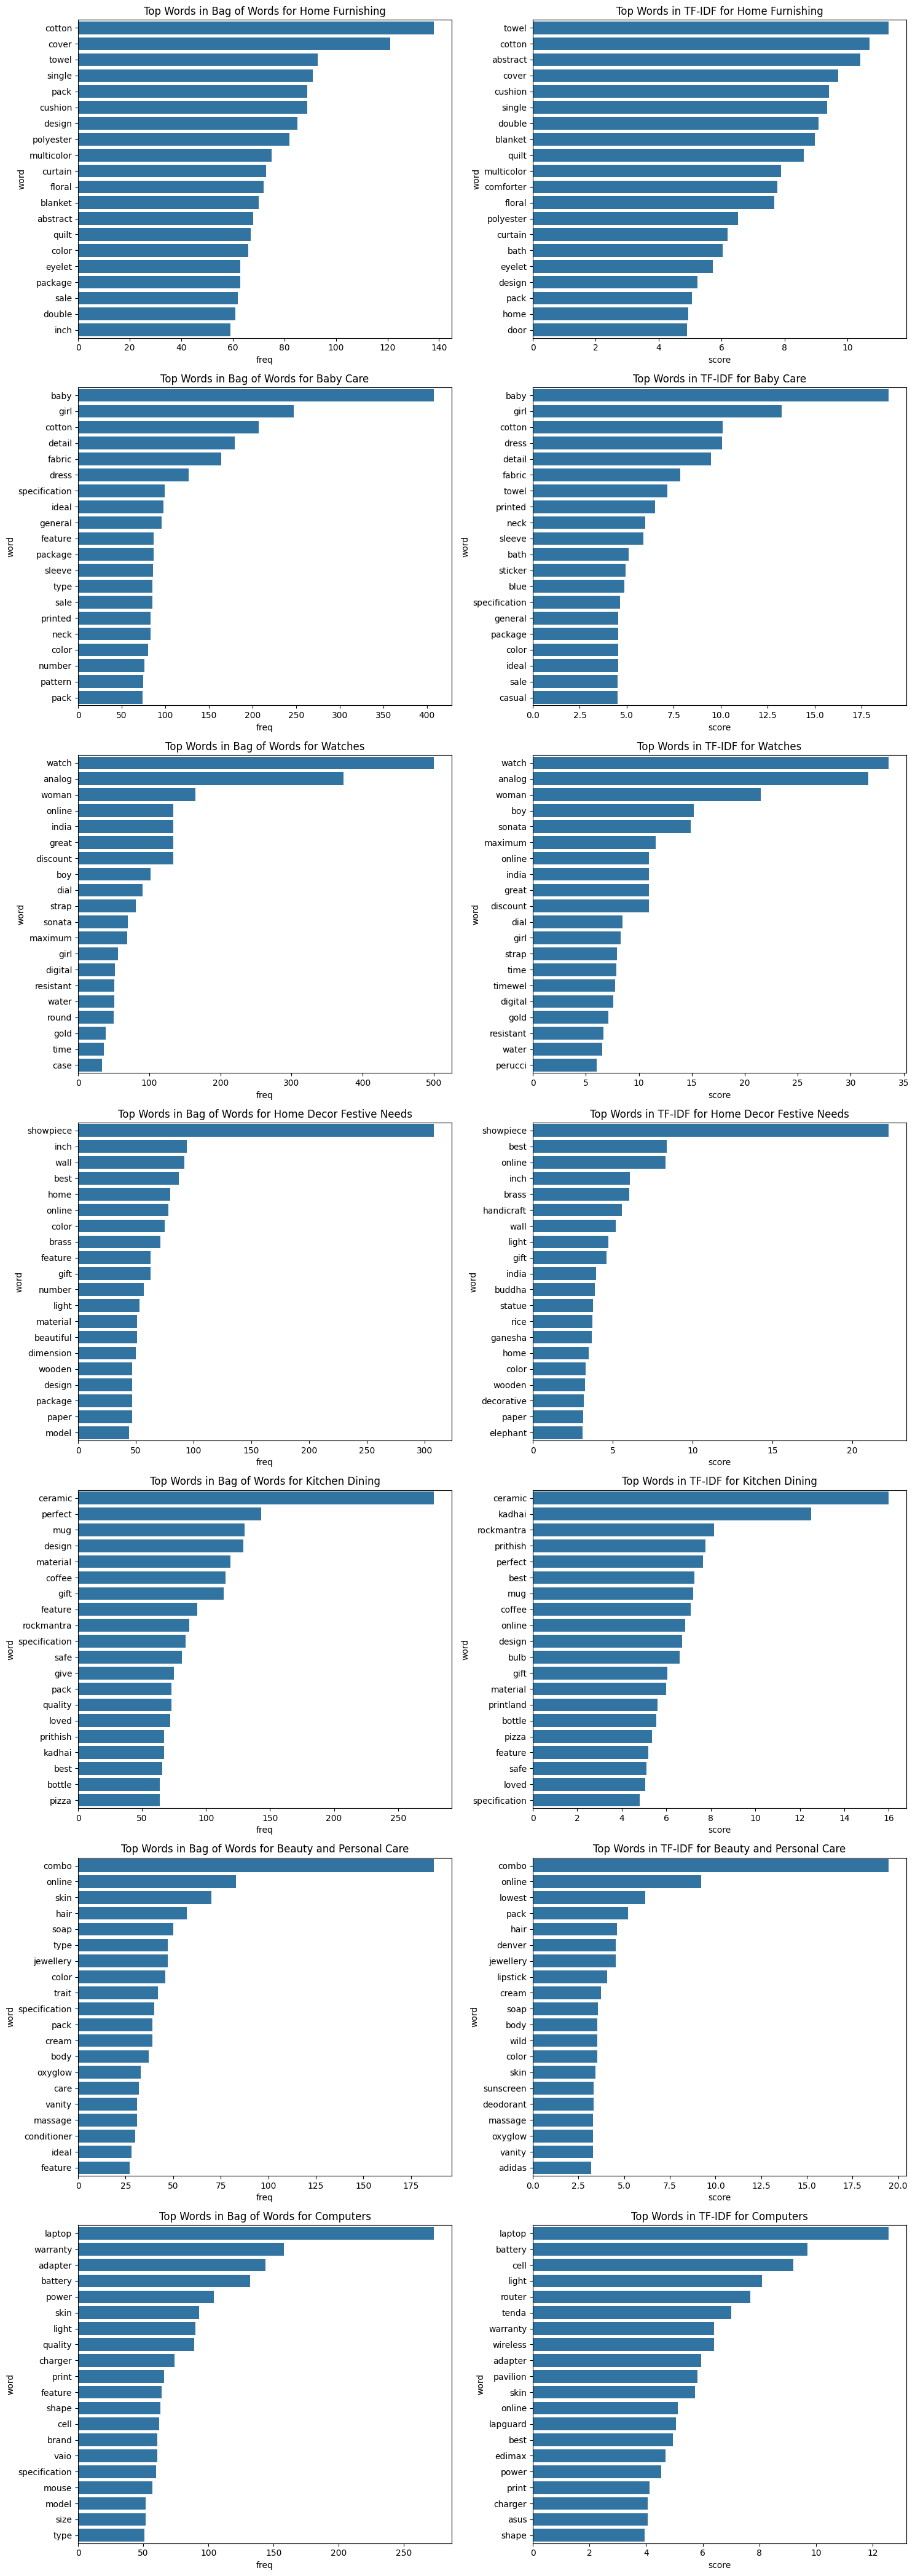

In [ ]:
# TD-IDF and BoW top words
plot_top_words_by_category(data, 'category', 'text')

In [ ]:
# Encoding categories
encode_fast = {
    'Home Furnishing': 0,
    'Baby Care': 1,
    'Watches': 2,
    'Home Decor Festive Needs': 3,
    'Kitchen Dining': 4,
    'Beauty and Personal Care': 5,
    'Computers': 6
}
data['encoded_cat'] = data['category'].map(encode_fast)

y_cat_num = data['encoded_cat']
l_cat = list(data['category'].unique())
N_CLUSTERS = len(l_cat)
y = y_cat_num.values
NB_CLASSES = y.max() + 1
y_one_hot = to_categorical(y, num_classes=NB_CLASSES)

ARI :  0.4656 time :  12.0


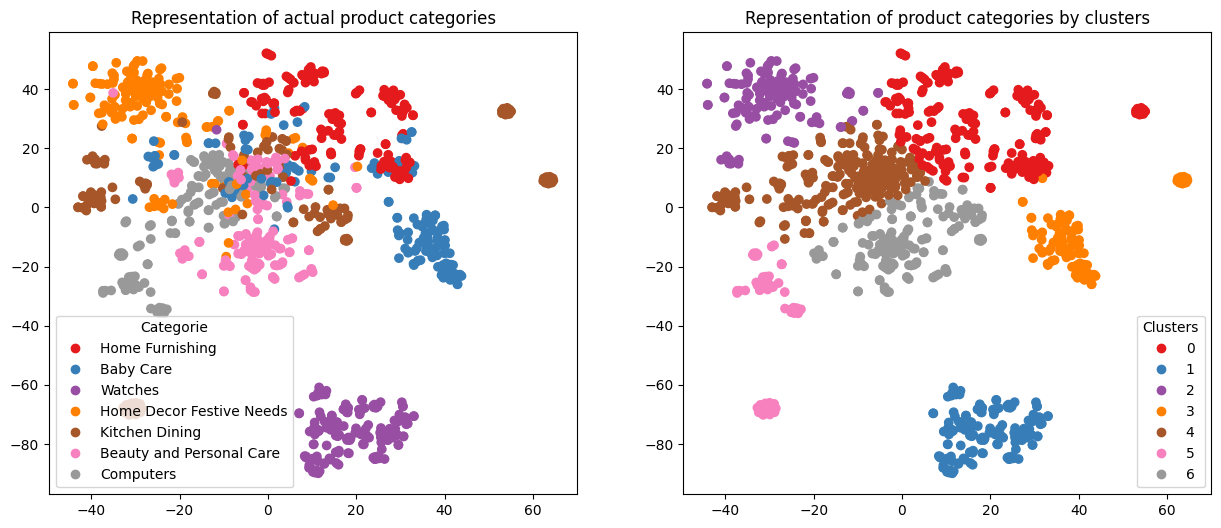

ARI :  0.4656


In [ ]:
# Example for BoW features
ARI_bow, X_tsne_bow, labels_bow = ARI_fct(bow_features, N_CLUSTERS, y_cat_num)
TSNE_visu_fct(X_tsne_bow, y_cat_num, labels_bow, ARI_bow)

ARI :  0.2405 time :  8.0


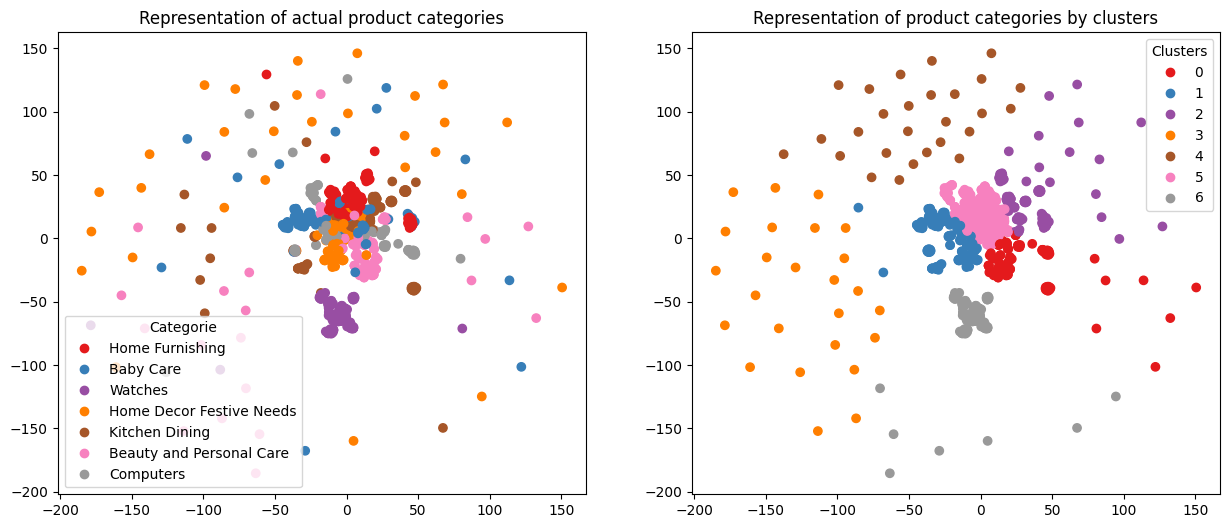

ARI :  0.2405


In [ ]:
# Example for TF-IDF features
ARI_tfidf, X_tsne_tfidf, labels_tfidf = ARI_fct(tfidf_features, N_CLUSTERS,
                                                y_cat_num)
TSNE_visu_fct(X_tsne_tfidf, y_cat_num, labels_tfidf, ARI_tfidf)

<div class="alert-success">
→ The Bag of Words (BoW) model may perform better with lemmatized data, as it effectively captures key concepts through word frequency, especially in texts with varied morphological forms.<br>
→ TF-IDF could underweight significant but frequently occurring terms, potentially affecting clustering performance when dealing with repetitive yet important terms.<br>
→ BoW's simplicity can be more informative for certain datasets where distinct categories are defined by the presence of specific keywords.<br>
→ Lemmatization reduces word form variability, aligning well with BoW's emphasis on direct word frequency for pattern detection.
</div>

****

### **B. Words/Sentences Embedding**

Embeddings represent words or sentences as dense vectors, capturing context and semantic relationships, unlike Bag of Words which merely counts word frequency without context understanding.

- **Words embedding using FastText**

FastText is a word embedding model developed by Facebook that extends the concept of word2vec to take into account substrings (n-grams).

The model is designed to work well with non-lemmatized data, because it takes into account character substrings and can therefore handle morphological variations.

In [ ]:
data.head()

,uniq_id,category,description,cleaned_tokens,lemmatized_tokens,lemmas_length,word_diversity,text,encoded_cat
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,Elegance Polyester Multicolor Abstract Eyelet ...,"[elegance, polyester, multicolor, abstract, ey...","[elegance, polyester, multicolor, abstract, ey...",139,0.611511,elegance polyester multicolor abstract eyelet ...,0
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,Sathiyas Cotton Bath Towel Specifications of S...,"[sathiyas, cotton, bath, towel, specifications...","[sathiyas, cotton, bath, towel, specification,...",58,0.568966,sathiyas cotton bath towel specification sathi...,1
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,Eurospa Cotton Terry Face Towel Set Key Featur...,"[eurospa, cotton, terry, face, towel, set, key...","[eurospa, cotton, terry, face, towel, feature,...",127,0.559055,eurospa cotton terry face towel feature eurosp...,1
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,SANTOSH ROYAL FASHION Cotton Printed King size...,"[santosh, royal, fashion, cotton, printed, kin...","[santosh, royal, fashion, cotton, printed, kin...",108,0.425926,santosh royal fashion cotton printed king size...,0
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,Jaipur Print Cotton Floral King sized Double B...,"[jaipur, print, cotton, floral, king, sized, d...","[jaipur, print, cotton, floral, king, sized, d...",136,0.477941,jaipur print cotton floral king sized double b...,0


In [ ]:
fasttext_sentences = data['text']
X = np.asarray([i for i in fasttext_sentences])

In [ ]:
# Train test split
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y_one_hot,
                                                  test_size=0.199,
                                                  stratify=y_one_hot,
                                                  random_state=42)

In [ ]:
print(f"Number of training sentences: {len(X_train)}")

Number of training sentences: 838


In [ ]:
# Define the objective function
def objective(trial):
    # Proposal of hyperparameters to test
    lr = trial.suggest_float('lr', 0.1, 1.0)
    epoch = trial.suggest_int('epoch', 5, 100)
    ws = trial.suggest_int('ws', 3, 7)
    minCount = trial.suggest_int('minCount', 1, 3)
    neg = trial.suggest_int('neg', 5, 15)
    wordNgrams = trial.suggest_int('wordNgrams', 1, 3)

    # Creation of the FastText training file for this event
    with open('training_data_fasttext.txt', 'w', encoding='utf-8') as f:
        for text in X_train:
            f.write(text + '\n')
    try:
        # Training the FastText model
        fasttext_model = fasttext.train_unsupervised(
            'training_data_fasttext.txt',
            model='skipgram',
            lr=lr,
            epoch=epoch,
            ws=ws,
            minCount=minCount,
            neg=neg,
            wordNgrams=wordNgrams)

        # Vectorization of validation data
        X_train_vectors = np.array(
            [fasttext_model.get_sentence_vector(text) for text in X_train])
        X_val_vectors = np.array(
            [fasttext_model.get_sentence_vector(text) for text in X_val])
        y_train_num = [np.argmax(y) for y in y_train]
        y_val_num = [np.argmax(y) for y in y_val]

        # Classification and evaluation
        classifier = LogisticRegression(max_iter=1000)
        classifier.fit(X_train_vectors, y_train_num)
        y_val_pred = classifier.predict(X_val_vectors)

        f1 = f1_score(y_val_num, y_val_pred, average='weighted')
        recall = recall_score(y_val_num, y_val_pred, average='weighted')

        combined_score = (recall + f1) / 2

        return combined_score
    except RuntimeError as e:
        print(
            f'Encountered a RuntimeError for trial with parameters: {trial.params}'
        )
        print(str(e))
        return None


# Creation of the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Results
print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Combined score:', trial.value)
print('  Hyperparameters:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-04-20 00:03:05,299] A new study created in memory with name: no-name-ed4b87f8-2136-4150-b6a1-ab98f2b0fabe
[W 2024-04-20 00:03:06,336] Trial 0 failed with parameters: {'lr': 0.8264678059848579, 'epoch': 21, 'ws': 4, 'minCount': 2, 'neg': 10, 'wordNgrams': 3} because of the following error: The value None could not be cast to float..
[W 2024-04-20 00:03:06,337] Trial 0 failed with value None.


Encountered a RuntimeError for trial with parameters: {'lr': 0.8264678059848579, 'epoch': 21, 'ws': 4, 'minCount': 2, 'neg': 10, 'wordNgrams': 3}
Encountered NaN.


[I 2024-04-20 00:03:10,422] Trial 1 finished with value: 0.8745109202032444 and parameters: {'lr': 0.444964017900356, 'epoch': 21, 'ws': 3, 'minCount': 1, 'neg': 11, 'wordNgrams': 2}. Best is trial 1 with value: 0.8745109202032444.
[W 2024-04-20 00:03:11,429] Trial 2 failed with parameters: {'lr': 0.7615226655197327, 'epoch': 20, 'ws': 4, 'minCount': 1, 'neg': 13, 'wordNgrams': 1} because of the following error: The value None could not be cast to float..
[W 2024-04-20 00:03:11,430] Trial 2 failed with value None.


Encountered a RuntimeError for trial with parameters: {'lr': 0.7615226655197327, 'epoch': 20, 'ws': 4, 'minCount': 1, 'neg': 13, 'wordNgrams': 1}
Encountered NaN.


[W 2024-04-20 00:03:12,751] Trial 3 failed with parameters: {'lr': 0.5834015681416119, 'epoch': 56, 'ws': 3, 'minCount': 3, 'neg': 7, 'wordNgrams': 1} because of the following error: The value None could not be cast to float..
[W 2024-04-20 00:03:12,752] Trial 3 failed with value None.


Encountered a RuntimeError for trial with parameters: {'lr': 0.5834015681416119, 'epoch': 56, 'ws': 3, 'minCount': 3, 'neg': 7, 'wordNgrams': 1}
Encountered NaN.


[W 2024-04-20 00:03:13,883] Trial 4 failed with parameters: {'lr': 0.6924160981693847, 'epoch': 77, 'ws': 7, 'minCount': 2, 'neg': 5, 'wordNgrams': 2} because of the following error: The value None could not be cast to float..
[W 2024-04-20 00:03:13,884] Trial 4 failed with value None.


Encountered a RuntimeError for trial with parameters: {'lr': 0.6924160981693847, 'epoch': 77, 'ws': 7, 'minCount': 2, 'neg': 5, 'wordNgrams': 2}
Encountered NaN.


[I 2024-04-20 00:03:24,683] Trial 5 finished with value: 0.8499742235089964 and parameters: {'lr': 0.28852906528792716, 'epoch': 51, 'ws': 4, 'minCount': 2, 'neg': 14, 'wordNgrams': 3}. Best is trial 1 with value: 0.8745109202032444.
[W 2024-04-20 00:03:25,716] Trial 6 failed with parameters: {'lr': 0.8678175654135264, 'epoch': 92, 'ws': 6, 'minCount': 3, 'neg': 11, 'wordNgrams': 1} because of the following error: The value None could not be cast to float..
[W 2024-04-20 00:03:25,718] Trial 6 failed with value None.


Encountered a RuntimeError for trial with parameters: {'lr': 0.8678175654135264, 'epoch': 92, 'ws': 6, 'minCount': 3, 'neg': 11, 'wordNgrams': 1}
Encountered NaN.


[W 2024-04-20 00:03:32,980] Trial 7 failed with parameters: {'lr': 0.36942486212311154, 'epoch': 89, 'ws': 7, 'minCount': 2, 'neg': 8, 'wordNgrams': 1} because of the following error: The value None could not be cast to float..
[W 2024-04-20 00:03:32,981] Trial 7 failed with value None.


Encountered a RuntimeError for trial with parameters: {'lr': 0.36942486212311154, 'epoch': 89, 'ws': 7, 'minCount': 2, 'neg': 8, 'wordNgrams': 1}
Encountered NaN.


[I 2024-04-20 00:03:49,577] Trial 8 finished with value: 0.8317612657064083 and parameters: {'lr': 0.34524201261460497, 'epoch': 87, 'ws': 5, 'minCount': 1, 'neg': 9, 'wordNgrams': 3}. Best is trial 1 with value: 0.8745109202032444.
[I 2024-04-20 00:03:53,741] Trial 9 finished with value: 0.8603296850394752 and parameters: {'lr': 0.16582778032944007, 'epoch': 17, 'ws': 5, 'minCount': 3, 'neg': 10, 'wordNgrams': 3}. Best is trial 1 with value: 0.8745109202032444.


Number of finished trials: 10
Best trial:
  Combined score: 0.8745109202032444
  Hyperparameters:
    lr: 0.444964017900356
    epoch: 21
    ws: 3
    minCount: 1
    neg: 11
    wordNgrams: 2


In [ ]:
one_of_best_params_founded = {
    'lr': 0.17273306597106958,
    'epoch': 37,
    'ws': 5,
    'minCount': 2,
    'neg': 12,
    'wordNgrams': 1
}

# Creating the training file
with open('training_data_fasttext.txt', 'w', encoding='utf-8') as f:
    for text in X_train:
        f.write(text + '\n')

# FastText re-training
fasttext_model = fasttext.train_unsupervised(
    'training_data_fasttext.txt',
    model='skipgram',
    lr=one_of_best_params_founded['lr'],
    epoch=one_of_best_params_founded['epoch'],
    ws=one_of_best_params_founded['ws'],
    minCount=one_of_best_params_founded['minCount'],
    neg=one_of_best_params_founded['neg'],
    wordNgrams=one_of_best_params_founded['wordNgrams'])

print("FastText Model retrained with best hyperparameters.")

FastText Model retrained with best hyperparameters.


In [ ]:
# Create the embedding matrix for all unique words
unique_words = {
    word
    for sentence in fasttext_sentences for word in sentence.split()
}
embedding_matrix = {
    word: fasttext_model.get_word_vector(word)
    for word in unique_words
}

category_embeddings = {}
for category in data['category'].unique():
    category_words = data[data['category'] ==
                          category]['cleaned_tokens'].explode().unique()
    category_words = [
        word for word in category_words if word in embedding_matrix
    ]

    # Calculate mean embedding for the category
    if category_words:  # Ensure there are words to process
        category_embeddings[category] = np.mean(
            [embedding_matrix[word] for word in category_words], axis=0)

# Verify category embeddings
print(f"Number of categories processed: {len(category_embeddings)}")

Number of categories processed: 7


In [ ]:
# Intra-category similarity
intra_category_similarity = {}
for category, embeddings in category_embeddings.items():
    # No need to recreate embeddings array, directly use category embeddings
    sim_matrix = cosine_similarity([embeddings], [embeddings])
    intra_category_similarity[category] = np.mean(sim_matrix)

# Inter-category similarity
inter_category_similarity = {}
categories = list(category_embeddings.keys())
for i, category1 in enumerate(categories):
    for category2 in categories[i + 1:]:
        if category_embeddings[category1].size > 0 and category_embeddings[
                category2].size > 0:
            sim_matrix = cosine_similarity([category_embeddings[category1]],
                                           [category_embeddings[category2]])
            inter_category_similarity[(category1,
                                       category2)] = np.mean(sim_matrix)

# Print results
print("Intra-category Cosine Similarity:")
for category, similarity in intra_category_similarity.items():
    print(f"{category}: {similarity}")

print("\nInter-category Cosine Similarity:")
for categories_pair, similarity in inter_category_similarity.items():
    print(f"{categories_pair}: {similarity}")

Intra-category Cosine Similarity:
Home Furnishing: 1.0
Baby Care: 1.0000001192092896
Watches: 0.9999998807907104
Home Decor Festive Needs: 1.0000001192092896
Kitchen Dining: 1.0
Beauty and Personal Care: 0.9999998211860657
Computers: 1.0

Inter-category Cosine Similarity:
('Home Furnishing', 'Baby Care'): 0.963191568851471
('Home Furnishing', 'Watches'): 0.8964574337005615
('Home Furnishing', 'Home Decor Festive Needs'): 0.9563775658607483
('Home Furnishing', 'Kitchen Dining'): 0.949097752571106
('Home Furnishing', 'Beauty and Personal Care'): 0.9483425617218018
('Home Furnishing', 'Computers'): 0.9177678227424622
('Baby Care', 'Watches'): 0.9200616478919983
('Baby Care', 'Home Decor Festive Needs'): 0.9580168128013611
('Baby Care', 'Kitchen Dining'): 0.9607446789741516
('Baby Care', 'Beauty and Personal Care'): 0.9653781056404114
('Baby Care', 'Computers'): 0.9453908801078796
('Watches', 'Home Decor Festive Needs'): 0.9223748445510864
('Watches', 'Kitchen Dining'): 0.9239509105682373


In [ ]:
# Initialize an empty list to hold sentence embeddings
fasttext_features = []
for sentence in fasttext_sentences:
    tokens = sentence.split()
    embeddings = [
        fasttext_model.get_word_vector(token) for token in tokens
        if token in embedding_matrix
    ]
    # Compute the mean of these embeddings to get a single vector for the sentence
    if embeddings:
        sentence_embedding = np.mean(embeddings, axis=0)
    else:
        sentence_embedding = np.zeros(fasttext_model.get_dimension())
    fasttext_features.append(sentence_embedding)

# Convert the list of embeddings into a NumPy array
fasttext_features = np.array(fasttext_features)

ARI :  0.4922 time :  6.0


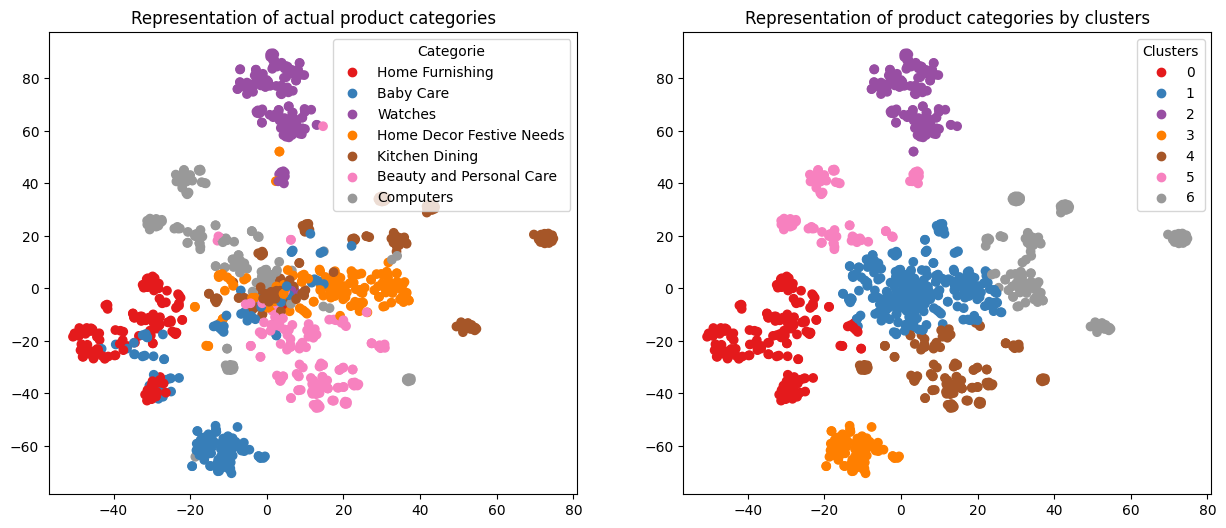

ARI :  0.4922


In [ ]:
# Example for fasttext features
ARI_fasttext, X_tsne_fasttext, labels_fasttext = ARI_fct(
    fasttext_features, N_CLUSTERS, y_cat_num)
TSNE_visu_fct(X_tsne_fasttext, y_cat_num, labels_fasttext, ARI_fasttext)

**Summary of strategy for FastText with hyperparameter optimization**

**Key steps**
1. Data preparation:
  - Sentences: convert cleaned tokens into complete sentences.
  - Unique Words: extract unique words to create an embedding matrix.
2. Configuring FastText:
  - Model: use the skipgram model suitable for large text corpora.
  - Hyperparameters: adjust parameters such as lr, epoch, ws, minCount, neg, and wordNgrams through Optuna.
3. Optimization with Optuna:
  - Objective function: combine recall and F1-score to optimize classification performance.
  - Optuna study: systematically explore and optimize hyperparameters.
2. Visualization and clustering:
  - t-SNE: apply t-SNE for dimensionality reduction to visualize data in a 2D space.
  - Clustering: use K-Means to identify clusters within the t-SNE transformed data.
  - ARI Calculation: compute the Adjusted Rand Index to measure the similarity between true labels and clustering labels.

**Performance analysis**
 - Intra-category similarity: scores close to 1.0 indicate high lexical consistency within categories.
 - Inter-category similarity: scores ranging from 0.89 to 0.97, demonstrating good separation between categories.

**Conclusion**

 - Optimizing FastText via Optuna with a focus on a combined score of recall and F1-score has enabled the development of a robust model for textual classification.
 - Setting a similarity threshold of 0.95 maximizes the model's effectiveness in terms of precision and recall, suited to the demands of precise classification across various product categories.

____________________________________

- **Sentences embedding using BERT**

The bert-base-uncased model is chosen for its general-purpose applicability, efficient balance between size and performance, and its ability to handle diverse text without the need for case sensitivity. These attributes make it a suitable choice for product classification tasks, where the dataset encompasses a broad range of products and descriptions.






In [ ]:
# Initialize BERT model and tokenizer
model_type = 'bert-base-uncased'
bert_model = TFAutoModel.from_pretrained(model_type)
bert_tokenizer = AutoTokenizer.from_pretrained(model_type)

# Parameters
bert_sentences = data['text'].tolist()
max_length = 512
batch_size = 10

bert_sentence_embeddings = get_bert_embeddings(bert_sentences, bert_model,
                                               bert_tokenizer, max_length)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

33/33 [==============================] - 54s 1s/step


In [ ]:
# Calculate mean embedding for the category
bert_category_embeddings = {}
for category in data['category'].unique():
    # Get indexes of category descriptions
    category_indices = data[data['category'] == category].index
    valid_indices = [
        index for index in category_indices
        if index < len(bert_sentence_embeddings)
    ]
    if valid_indices:
        bert_category_embeddings[category] = np.mean(
            bert_sentence_embeddings[valid_indices], axis=0)

# Verify category embeddings
print(f"Number of categories processed: {len(bert_category_embeddings)}")

Number of categories processed: 7


In [ ]:
# Intra-category similarity
bert_intra_category_similarity = {}
for category, embeddings in bert_category_embeddings.items():
    # No need to recreate embeddings array, directly use category embeddings
    bert_sim_matrix1 = cosine_similarity([embeddings], [embeddings])
    bert_intra_category_similarity[category] = np.mean(bert_sim_matrix1)

# Inter-category similarity
bert_inter_category_similarity = {}
bert_categories = list(bert_category_embeddings.keys())
for i, category1 in enumerate(bert_categories):
    for category2 in bert_categories[i + 1:]:
        if bert_category_embeddings[
                category1].size > 0 and bert_category_embeddings[
                    category2].size > 0:
            bert_sim_matrix2 = cosine_similarity(
                [bert_category_embeddings[category1]],
                [bert_category_embeddings[category2]])
            bert_inter_category_similarity[(
                category1, category2)] = np.mean(bert_sim_matrix2)

# Print results
print("Intra-category Cosine Similarity:")
for category, similarity in bert_intra_category_similarity.items():
    print(f"{category}: {similarity}")

print("\nInter-category Cosine Similarity:")
for categories_pair, similarity in bert_inter_category_similarity.items():
    print(f"{categories_pair}: {similarity}")

Intra-category Cosine Similarity:
Home Furnishing: 1.000000238418579
Baby Care: 0.9999998807907104
Watches: 0.9999997615814209
Home Decor Festive Needs: 1.0
Kitchen Dining: 0.9999999403953552
Beauty and Personal Care: 1.0
Computers: 0.9999998807907104

Inter-category Cosine Similarity:
('Home Furnishing', 'Baby Care'): 0.990598201751709
('Home Furnishing', 'Watches'): 0.9358155727386475
('Home Furnishing', 'Home Decor Festive Needs'): 0.9833041429519653
('Home Furnishing', 'Kitchen Dining'): 0.9810452461242676
('Home Furnishing', 'Beauty and Personal Care'): 0.9690905809402466
('Home Furnishing', 'Computers'): 0.9759129881858826
('Baby Care', 'Watches'): 0.941764235496521
('Baby Care', 'Home Decor Festive Needs'): 0.9779558181762695
('Baby Care', 'Kitchen Dining'): 0.9810420274734497
('Baby Care', 'Beauty and Personal Care'): 0.9686291813850403
('Baby Care', 'Computers'): 0.9730987548828125
('Watches', 'Home Decor Festive Needs'): 0.9458340406417847
('Watches', 'Kitchen Dining'): 0.941

ARI :  0.2676 time :  12.0


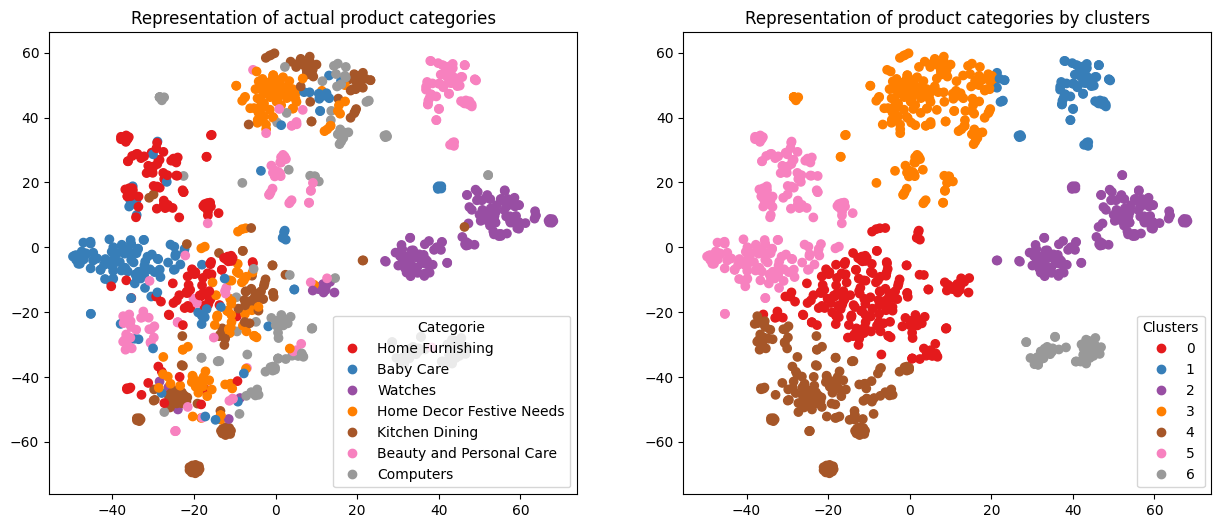

ARI :  0.2676


In [ ]:
# Example for BERT features
ARI_bert, X_tsne_bert, labels_bert = ARI_fct(bert_sentence_embeddings,
                                             N_CLUSTERS, y_cat_num)
TSNE_visu_fct(X_tsne_bert, y_cat_num, labels_bert, ARI_bert)

**Summary of strategy for BERT with t-SNE visualization**

**Key steps**
1. Data preparation:
  - Sentences: use preprocessed sentences suitable for BERT.
  - BERT embeddings: extract embeddings for each sentence using the BERT model.
2. Visualization and clustering:
  - t-SNE: apply t-SNE for dimensionality reduction to visualize data in a 2D space.
  - Clustering: use K-Means to identify clusters within the t-SNE transformed data.
  - ARI calculation: compute the Adjusted Rand Index to measure the similarity between true labels and clustering labels.

**Performance analysis**
- Intra-category similarity: high cosine similarity scores close to 1.0 demonstrate that within-category embeddings are closely clustered, indicating high internal consistency.
- Inter-category similarity: scores ranging from 0.94 to 0.99, demonstrating bad separation between categories.

**Conclusion**
- The analysis of BERT embeddings reveals mixed results for product categorization. While intra-category cosine similarities are high, indicating that BERT captures semantic nuances within categories well, the ARI score of 0.26 suggests room for improvement in differentiating between categories.
- Compared to FastText's ARI score of 0.46, BERT's lower ARI score could be a result of several factors, such as the nature of the dataset, the preprocessing steps, or the clustering technique used.
- The relatively lower inter-category similarity scores hint at BERT’s potential for capturing semantic differences across categories, but this does not translate as effectively into distinct clusters as it does with FastText.

____________________________________

- **Sentences embedding using USE**

USE is specifically trained to understand the full meaning of sentences. It is optimized for processing entire sentences, not just individual words or tokens.
It is therefore preferable to use complete sentences to fully benefit from its ability to analyze the context and structure of sentences.

In [ ]:
# Loading the USE model from TensorFlow Hub
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
use_sentences = data['text'].tolist()

use_embeddings = get_use_embeddings(use_sentences)

In [ ]:
# Calculate mean embedding for the category
use_category_embeddings = {}
for category in data['category'].unique():
    # Get indexes of category descriptions
    category_indices = data[data['category'] == category].index
    valid_indices = [
        index for index in category_indices if index < len(use_embeddings)
    ]
    if valid_indices:
        use_category_embeddings[category] = np.mean(
            use_embeddings[valid_indices], axis=0)

# Verify category embeddings
print(f"Number of categories processed: {len(use_category_embeddings)}")

Number of categories processed: 7


In [ ]:
# Intra-category similarity
use_intra_category_similarity = {}
for category, embeddings in use_category_embeddings.items():
    # No need to recreate embeddings array, directly use category embeddings
    use_sim_matrix1 = cosine_similarity([embeddings], [embeddings])
    use_intra_category_similarity[category] = np.mean(use_sim_matrix1)

# Inter-category similarity
use_inter_category_similarity = {}
use_categories = list(use_category_embeddings.keys())
for i, category1 in enumerate(use_categories):
    for category2 in use_categories[i + 1:]:
        if use_category_embeddings[
                category1].size > 0 and use_category_embeddings[
                    category2].size > 0:
            use_sim_matrix2 = cosine_similarity(
                [use_category_embeddings[category1]],
                [use_category_embeddings[category2]])
            use_inter_category_similarity[(
                category1, category2)] = np.mean(use_sim_matrix2)

# Print results
print("Intra-category Cosine Similarity:")
for category, similarity in use_intra_category_similarity.items():
    print(f"{category}: {similarity}")

print("\nInter-category Cosine Similarity:")
for categories_pair, similarity in use_inter_category_similarity.items():
    print(f"{categories_pair}: {similarity}")

Intra-category Cosine Similarity:
Home Furnishing: 1.0
Baby Care: 0.9999998807907104
Watches: 0.9999998211860657
Home Decor Festive Needs: 1.0
Kitchen Dining: 1.0000001192092896
Beauty and Personal Care: 0.9999997615814209
Computers: 1.000000238418579

Inter-category Cosine Similarity:
('Home Furnishing', 'Baby Care'): 0.8891814947128296
('Home Furnishing', 'Watches'): 0.3743519186973572
('Home Furnishing', 'Home Decor Festive Needs'): 0.814839243888855
('Home Furnishing', 'Kitchen Dining'): 0.676446795463562
('Home Furnishing', 'Beauty and Personal Care'): 0.711448609828949
('Home Furnishing', 'Computers'): 0.6566705703735352
('Baby Care', 'Watches'): 0.43764567375183105
('Baby Care', 'Home Decor Festive Needs'): 0.7729852795600891
('Baby Care', 'Kitchen Dining'): 0.6884437799453735
('Baby Care', 'Beauty and Personal Care'): 0.6743647456169128
('Baby Care', 'Computers'): 0.6739583015441895
('Watches', 'Home Decor Festive Needs'): 0.4303542971611023
('Watches', 'Kitchen Dining'): 0.408

ARI :  0.5496 time :  8.0


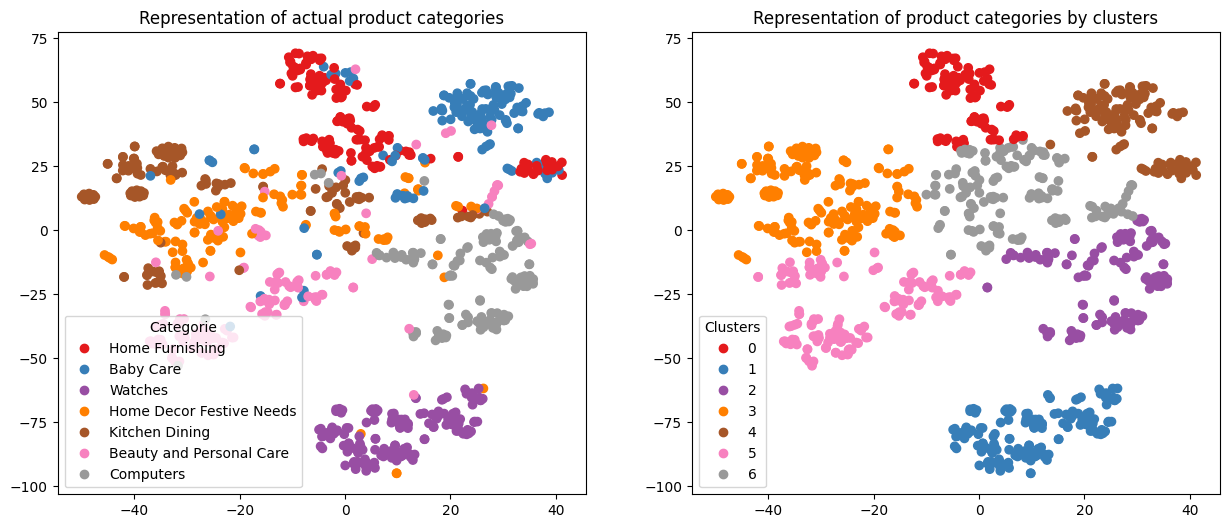

ARI :  0.5496


In [ ]:
# Example for USE features
ARI_use, X_tsne_use, labels_use = ARI_fct(use_embeddings, N_CLUSTERS,
                                          y_cat_num)
TSNE_visu_fct(X_tsne_use, y_cat_num, labels_use, ARI_use)

**Summary of Strategy for USE with t-SNE visualization**

**Key steps**
1. Data preparation:
 - Utilize processed sentences suitable for the USE model.
 - Generate sentence embeddings using the Universal Sentence Encoder.
2. Visualization and clustering:
 - Employ t-SNE for dimensionality reduction to visualize data in a two-dimensional space.
 - Apply K-Means to identify distinct clusters within the t-SNE transformed data.
 - Use the Adjusted Rand Index (ARI) to measure the congruence between true category labels and clustering outcomes.

**Performance analysis**
- Intra-category similarity: high cosine similarity scores close to 1.0 indicate tightly clustered embeddings within categories, reflecting consistent semantic coherence.
- Inter-category similarity: scores show meaningful separation between categories, with the lowest at approximately 0.37 for 'Home Furnishing' and 'Watches', and the highest at around 0.89 for 'Home Furnishing' and 'Baby Care'. This range implies that while there is distinct separation in semantic space for certain category pairs, others may have overlapping semantic characteristics.

**Conclusion**
- The analysis of USE embeddings presents a nuanced picture for product categorization. The intra-category cosine similarity scores are uniformly high, demonstrating that the model reliably captures semantic consistency within categories.
- The ARI score, in this case, doesn't fully capture the model's effectiveness due to the nuanced semantic overlaps that the inter-category similarity scores reveal. These overlaps suggest that some product categories share semantic commonalities that the model is sensitive to, which is both a strength and a challenge for classification.
- For practical categorization purposes, a similarity threshold could be set conservatively at 0.65, above the lowest inter-category similarity score, to ensure clear delineation while embracing the semantic richness across product descriptions.
- Compared to the results from other models like FastText and BERT, USE shows a particular strength in semantic distinction, though it requires careful threshold tuning to manage the overlap in semantic space effectively.

****